# hmmlearn

    model=hmm.MultinomialHMM(n_components=3, transmat_prior=transmat, startprob_prior=startprob, params="tse")
    model.n_features=4
    model.emissionprob_=np.array([[0, 1/2, 1/2, 0], [2/3, 0, 1/3, 0], [0, 0, 1/3, 2/3]])
    model.sample()
    
> NotFittedError: This MultinomialHMM instance is not fitted yet. Call 'fit' with appropriate arguments before using this method. 

Same with any combination of `init_params` or `params`

# [pomegranate](https://pomegranate.readthedocs.io/en/latest/index.html)

# Functions and imports

In [2]:
%matplotlib inline
from pomegranate import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns

def from_pomegranate_sample(sample, toggle=True):
    sample = {
        # An list of (State, Observation) tuples
        'state_seq': [(st.name, obs) for obs, st in zip(sample[0], sample[1][1:])],
        # The states alphabet
        'states': list(np.unique([s.name for s in sample[1][1:]])),
        # The observations alphabet
        'observations': list(np.unique(sample[0]))
    }
    
    # If the model represents devices toggles and not usages
    if toggle:
        state_seq=[]
        # All devices begin closed (TODO: probabilistic initial state)
        current_state = {k: False for k in sample['observations'] if k is not 'none'}

        for s, o in sample['state_seq']:
            if o is not 'none':
                current_state[o] = not current_state[o]

            state_seq.append(
                (s, [k for k,v in current_state.items() if v])
            )
        
        # In toggle mode, the state_seq is a list of (State, list of opened devices)
        # In other words, several devices can be opened simultaneously
        sample['state_seq'] = state_seq
    
    return sample

def usage_proba_to_toggle_proba(usage_proba):
    toggle_proba={}
    for k, v in usage_proba.items():
        if k == 'none':
            continue
        
        # P[X(t) = !X(t-1)] = 2 * P[X] * (1 - P[X])
        toggle_proba[k] = 2 * v * (1 - v)
    
    toggle_proba['none'] = 1 - sum(toggle_proba.values())
    return toggle_proba

def plot_device_usage_timeline(sample, toggle=True, figsize=(10,3), title=""):
    c_used = matplotlib.colors.hex2color("#444444")
    height = 0.5
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_style("white", {'legend.frameon': True})
    
    devices = sorted(sample["observations"])
    if 'none' in devices:
        devices.remove('none')
    devices_id={d: i for i, d in enumerate(devices)}
    print(devices_id)

    states = [None]*len(sample['state_seq'])
    for x, (state, d) in enumerate(sample['state_seq']):
        states[x] = state
        if toggle:
            for device in d:
                y = devices_id[device]
                ax.barh(left=x, bottom=devices_id[device],
                        height=height, width=1, color=c_used)
        else:
            if d == 'none':
                continue

            ax.barh(left=x, bottom=devices_id[d], 
                    height=height, width=1, color=c_used)
        
    sns.despine()
    
    ax.set_xticks(range(len(states)))
    ax.set_xticklabels(states)
    plt.xticks(rotation=-60, ha='left')
    
    ax.set_ylabel("Device")
    ax.set_ylim([-0.5, len(devices)-0.5])
    ax.set_yticks(range(len(devices)))
    ax.set_yticklabels(devices)
    
    if title != "":
        ax.set_title(title)
    
    plt.show()

## Sequential model

In [41]:
at_home_dist=DiscreteDistribution({'none': 0, 'phone': 1/2, 'home computer': 1/2, 'work station': 0})
in_transit_dist=DiscreteDistribution({'none': 2/3, 'phone': 1/3, 'home computer': 0, 'work station': 0})
at_work_dist=DiscreteDistribution({'none': 0, 'phone': 1/2, 'home computer': 0, 'work station': 1/2})

at_home_state=State(at_home_dist, name="At home")
in_transit_state=State(in_transit_dist, name="In transit")
at_work_state=State(at_work_dist, name="At work")

model=HiddenMarkovModel(name="Sequential user")
model.add_states([at_home_state, in_transit_state, at_work_state])
model.add_transition(model.start, at_home_state, 0.8)
model.add_transition(model.start, at_work_state, 0.2)
model.add_transition(at_home_state, at_home_state, 2/3)
model.add_transition(at_home_state, in_transit_state, 1/3)
model.add_transition(in_transit_state, in_transit_state, 1/3)
model.add_transition(in_transit_state, at_home_state, 1/3)
model.add_transition(in_transit_state, at_work_state, 1/3)
model.add_transition(at_work_state, at_work_state, 2/3)
model.add_transition(at_work_state, in_transit_state, 1/3)
model.bake()

In [42]:
res=model.sample(length=20, path=True)
sample=from_pomegranate_sample(res, toggle=False)

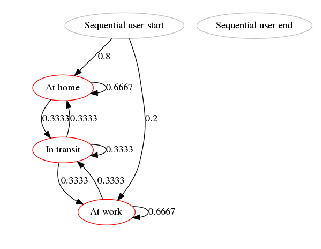

In [43]:
model.plot()

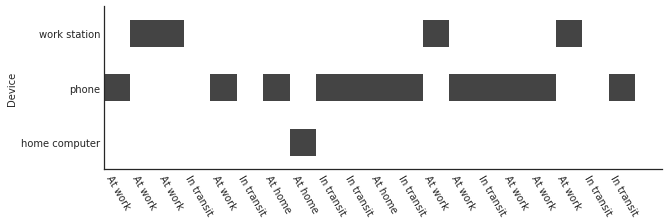

[('At work', 'phone'),
 ('At work', 'work station'),
 ('At work', 'work station'),
 ('In transit', 'none'),
 ('At work', 'phone'),
 ('In transit', 'none'),
 ('At home', 'phone'),
 ('At home', 'home computer'),
 ('In transit', 'phone'),
 ('In transit', 'phone'),
 ('At home', 'phone'),
 ('In transit', 'phone'),
 ('At work', 'work station'),
 ('At work', 'phone'),
 ('In transit', 'phone'),
 ('At work', 'phone'),
 ('At work', 'phone'),
 ('At work', 'work station'),
 ('In transit', 'none'),
 ('In transit', 'phone')]

In [44]:
plot_device_usage_timeline(sample, toggle=False)
sample['state_seq']

## Toggling model

In [58]:
at_home_proba={'none': 1/3, 'p': 1/3, 'h': 1/3, 'w': 0}
in_transit_proba={'none': 2/3, 'p': 1/3, 'h': 0, 'w': 0}
at_work_proba={'none': 1/3, 'p': 1/3, 'h': 0, 'w': 1/3}

at_home_toggle_proba=usage_proba_to_toggle_proba(at_home_proba)
in_transit_toggle_proba=usage_proba_to_toggle_proba(in_transit_proba)
at_work_toggle_proba=usage_proba_to_toggle_proba(at_work_proba)

print("At home:")
print(at_home_proba)
print(at_home_toggle_proba)
print("In transit:")
print(in_transit_proba)
print(in_transit_toggle_proba)
print("At work:")
print(at_work_proba)
print(at_work_toggle_proba)

At home:
{'h': 0.3333333333333333, 'p': 0.3333333333333333, 'none': 0.3333333333333333, 'w': 0}
{'h': 0.4444444444444445, 'p': 0.4444444444444445, 'none': 0.11111111111111105, 'w': 0}
In transit:
{'h': 0, 'p': 0.3333333333333333, 'none': 0.6666666666666666, 'w': 0}
{'h': 0, 'p': 0.4444444444444445, 'none': 0.5555555555555556, 'w': 0}
At work:
{'h': 0, 'p': 0.3333333333333333, 'none': 0.3333333333333333, 'w': 0.3333333333333333}
{'h': 0, 'p': 0.4444444444444445, 'none': 0.11111111111111105, 'w': 0.4444444444444445}


In [59]:
at_home_dist=DiscreteDistribution(at_home_toggle_proba)
in_transit_dist=DiscreteDistribution(in_transit_toggle_proba)
at_work_dist=DiscreteDistribution(at_work_toggle_proba)

at_home_state=State(at_home_dist, name="H")
in_transit_state=State(in_transit_dist, name="O")
at_work_state=State(at_work_dist, name="W")

model2=HiddenMarkovModel(name="Toggling user")
model2.add_states([at_home_state, in_transit_state, at_work_state])
model2.add_transition(model2.start, at_home_state, 0.8)
model2.add_transition(model2.start, at_work_state, 0.2)
model2.add_transition(at_home_state, at_home_state, 2/3)
model2.add_transition(at_home_state, in_transit_state, 1/3)
model2.add_transition(in_transit_state, in_transit_state, 1/3)
model2.add_transition(in_transit_state, at_home_state, 1/3)
model2.add_transition(in_transit_state, at_work_state, 1/3)
model2.add_transition(at_work_state, at_work_state, 2/3)
model2.add_transition(at_work_state, in_transit_state, 1/3)
model2.bake()

model2

{
    "start" : {
        "class" : "State",
        "name" : "Toggling user-start",
        "weight" : 1.0,
        "distribution" : null
    },
    "states" : [
        {
            "class" : "State",
            "name" : "H",
            "weight" : 1.0,
            "distribution" : {
                "class" : "Distribution",
                "name" : "DiscreteDistribution",
                "frozen" : false,
                "parameters" : [
                    {
                        "h" : 0.4444444444444445,
                        "p" : 0.4444444444444445,
                        "none" : 0.11111111111111105,
                        "w" : 0
                    }
                ]
            }
        },
        {
            "class" : "State",
            "name" : "O",
            "weight" : 1.0,
            "distribution" : {
                "class" : "Distribution",
                "name" : "DiscreteDistribution",
                "frozen" : false,
                "parameters" 

{'h': 0, 'p': 1, 'w': 2}


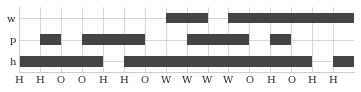

{'observations': ['h', 'p', 'w'],
 'state_seq': [('H', ['h']),
  ('H', ['h', 'p']),
  ('O', ['h']),
  ('O', ['h', 'p']),
  ('H', ['p']),
  ('H', ['h', 'p']),
  ('O', ['h']),
  ('W', ['h', 'w']),
  ('W', ['h', 'p', 'w']),
  ('W', ['h', 'p']),
  ('W', ['h', 'p', 'w']),
  ('O', ['h', 'w']),
  ('H', ['h', 'p', 'w']),
  ('O', ['h', 'w']),
  ('H', ['w']),
  ('H', ['h', 'w'])],
 'states': ['H', 'O', 'W']}

In [65]:
def plot_device_usage_timeline(sample, toggle=True, figsize=(6,1.5), title="", fn=""):
    c_used = matplotlib.colors.hex2color("#444444")
    height = 0.5
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_style("whitegrid", {'font.family': 'serif'})
    
    devices = sorted(sample["observations"])
    if 'none' in devices:
        devices.remove('none')
    devices_id={d: i for i, d in enumerate(devices)}
    print(devices_id)

    states = [None]*len(sample['state_seq'])
    for x, (state, d) in enumerate(sample['state_seq']):
        states[x] = state
        if toggle:
            for device in d:
                y = devices_id[device]
                ax.barh(left=x, bottom=devices_id[device],
                        height=height, width=1, color=c_used)
        else:
            if d == 'none':
                continue

            ax.barh(left=x, bottom=devices_id[d], 
                    height=height, width=1, color=c_used)
        
    sns.despine()
    
    ax.set_xlim([0, len(sample['state_seq'])])
    ax.set_xticks(range(len(states)))
    ax.set_xticklabels(states)
    #plt.xticks(rotation=-60, ha='left')
    
    #ax.set_ylabel("Device")
    ax.set_ylim([-0.5, len(devices)-0.5])
    ax.set_yticks(range(len(devices)))
    ax.set_yticklabels(devices)
    
    if title != "":
        ax.set_title(title)
    if fn != "":
        plt.savefig(fn)
    plt.show()

sample=from_pomegranate_sample(model2.sample(length=16, path=True))
plot_device_usage_timeline(sample, fn="sweet_god.svg", figsize=(6, 1.2))
sample